# Project 3 - Neutron Scattering and Absorption in Materials via Monte Carlo Simulations

Author: James Michael Patrick Brady
ID: 10459769

## The Project in Brief:

### Theory

A material may interact with neutrons incident on its surface. Given a macroscopic cross-sections $\Sigma_{absorb}$ and $\Sigma_{scatter}$, a neutron can be absorbed or scattered with the respective probabilities:

$P(absorb) = \frac{\Sigma_{absorb}}{\Sigma_{absorb} + \Sigma_{scatter}}$

$P(scatter) = \frac{\Sigma_{scatter}}{\Sigma_{absorb} + \Sigma_{scatter}}$

Scattering occurs isotropically without he presence of external factors, with some distance $x$ distributed according to some angles $\phi$ and $\theta$:
$x = r\sin{(\phi)}\cos(\theta)$ <br>
$y = r\sin{(\phi)}\sin(\theta)$ <br>
$z = r\cos{(\phi)}$ <br>

Each material will have a mean free path, $\lambda = \frac{1}{\Sigma_{absorb} + \Sigma_{scatter}}$ for scattering associated with it, with the probability of travelling some distance $r$ in the material being $\exp{(\frac{-r}{\lambda})}$. The angle around the $z$ axis, $\phi$ is distributed according to $\arccos(2U - 1)$.

When the cumulative probability function is found, distances $r$ can be distributed to $-\lambda \ln{(u_{i})}$, where $u_{i}$ is some randomly distributed uniform variable, $U ~ X[0,1)$.

These numbers could also be generated via pseudorandom generators to produce predicatble results, although these are susceptible to bias via lying on defined planes in 3D space, so are not always reliable.

Random numbers are used in brute force Monte Carlo methods to simulate many neutrons interacting with a material, given that analytic solutions are not possible, the random nature of the simulation allows for unbiased and accurate reults given large enough samples and unbaised random numbers.

### Summary of Project and Results
- Numpy's Uniform tables do distribute numbers randomly and uniformly, as it accurately generates well defined probabilities and it passes the spectral test
- This generation also works in 3D space.
- The RANDU LCG fails the spectral test and so indicates that LCGS are unreliable
- Isotropic steps can be generated easily, with step lengths distributed correctly according to the probability of travelling a distance in a material, as tested for non-scattering water.
- Single step data could be correctly manipulated to identify the mean free path of 0.45m.
- Simulations demonstrated accurate scattering, reflection and transmission probabilities for 10cm blocks of water, lead and graphite.
- Attenuation lengths could also be found for short thicknesses and were similar to expected values.
- Increasing number of neutrons simulated per simulation call decreases error as expected and does so to a better degree than varying the number of repetitions of the simulation.

## Initialisation of the Kernel

This is the setup for this project's instance of the kernel. NumPy, MatplotLib and Axes3D are imported for use in the project:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

%matplotlib notebook
# Pi is defined as a global constant for easier use (saves having to write np.pi every time)
PI = np.pi

plt.rcParams['figure.figsize'] = [8,8] # Sets universal figure size (it's easier to read than default)
plt.rcParams['font.size'] = '16' # Sets universal font size, which is easier to read than the default 12px font

## Part 1 - Checking That Numpy Uniform Tables Are Uniform
In order to have unbiased randomness so that steps are isotropic and step lengths are correcty distributed, we need to check that the uniform distribution $X \sim U[0,1)$ generated by NumPy is actually uniform. This can be done in two ways:
- Firstly, we can check that for a large number of points, $N$, distributed according to $X \sim U[0,1)$ return accurate values for a defined probability
- Secondly, we can check that the distribution does not experience the 'spectral problem' - where pseudorandom points lie along defined hyperplanes in 3D space rather than being isotropically distriubuted.

In order to check that returned probabilities are accurate, two areas will be taken:
- A square area, where $-0.5 < x < 0.5$ and $-0.5 < y < 0.5$, of size 1 unit$^{2}$
- A larger sqaure area, where $-1 < x < 1$ and $-1 < y < 1$, of size 4 units$^{2}$

Any point generated by a uniform table will be transformed to a range $[-1,1)$ via $f(X) = 2X - 1$. If a point falls within both regions it will be accepted, whereas if it exclusively falls within the larger square, it will be rejected. The probability of any point being accepted should be the ratio of the areas between the accepted region and the total region of the larger sqaure:

$P_{accept}(X) = \frac{A_{accept}}{A_{total}} = 0.25$

Using a Monte Carlo approach, if there are $n$ accepted points and $m$ rejected points, then the probability of being accepted can be estimated as:

$P_{accept}(X) = \frac{n}{n + m}$

Below is a test of this estimation for 10000 2D points:

The number of accepted points is: 2401
The number of rejected points is: 7599
The probability of being in the smaller square for 10000 points is 0.2401


<IPython.core.display.Javascript object>


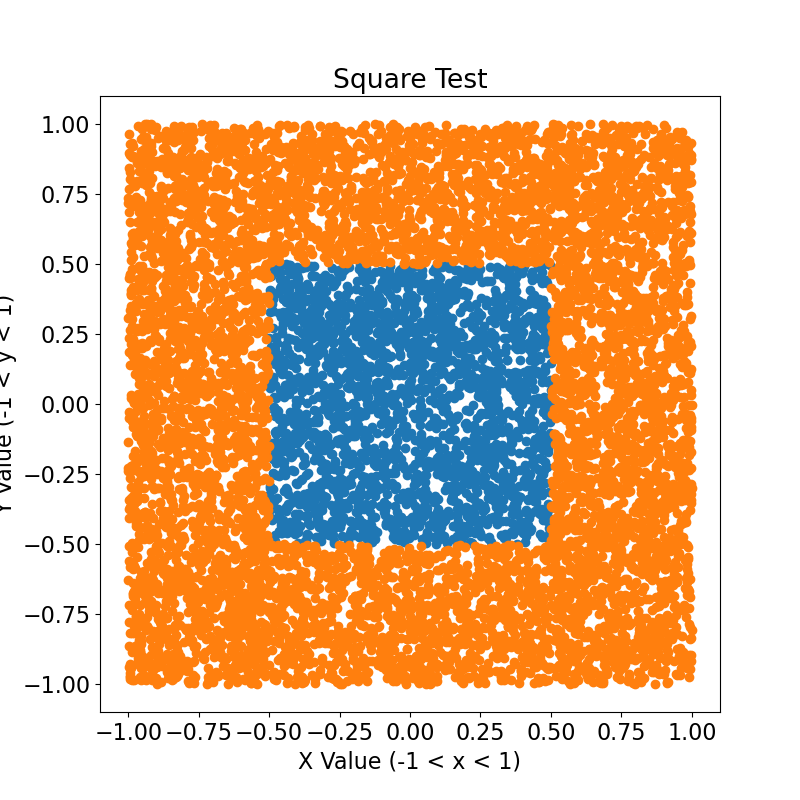

In [2]:
def square_check(n=1000, plot=False):
    # The unit areas of the accepted and rejected squares are 1 and 4 respectively
    # If distributed uniformly, the probability P(accept) -> 0.25 when n is large
    # Initialization
    accept, reject = 0, 0
    accept_list = np.zeros((0,2))
    reject_list = np.zeros((0,2))
    
    # Generating number tables by using the built-in size parameter
    x = 2*np.random.uniform(size=(n)) - 1
    y = 2*np.random.uniform(size=(n)) - 1
    
    # Checking if points fall in the acceptable region
    for i in range(n):
        arr = np.array([x[i],y[i]])
        if -0.5 < x[i] < 0.5 and -0.5 < y[i] < 0.5:
            accept += 1
            accept_list = np.vstack((accept_list,arr))
        else:
            reject += 1
            reject_list = np.vstack((reject_list,arr))
    
    # Returning generated probability 
    probability = accept/(accept + reject)
    
    # Plotting points as a visual guide, prevents a plot being made for every instance
    if plot:
        # Returning generated probability as a print 
        print("The number of accepted points is: {}".format(accept))
        print("The number of rejected points is: {}".format(reject))
        print("The probability of being in the smaller square for {0} points is {1:.4g}".format(n,probability))
        
        fig = plt.figure(figsize=(8,8))
        axes = fig.add_subplot(111)
        axes.set_xlabel("X Value (-1 < x < 1)")
        axes.set_ylabel("Y Value (-1 < y < 1)")
        axes.set_title("Square Test")
        plt.scatter(accept_list[:,0],accept_list[:,1])
        plt.scatter(reject_list[:,0],reject_list[:,1])
        plt.show()
    
    # Returns probability of event
    return probability

square_probability = square_check(10000, True)

As seen above, this seems to work as a good estimate of the probability for a large number of points, however it is not perfect. This can be easily rectified by taking multiple simulations and then by taking the mean probability of these simulations:

In [3]:
square_probs = np.array(square_probability)
counter = 0
while counter < 4:
    probability = square_check(10000)
    square_probs = np.append(square_probs, probability)
    counter += 1
    
probability_mean = np.mean(square_probs)
probability_deviation = np.std(square_probs)

print("The mean probability for 10000 points over {0} simulations is {1:.4g} with standard deviation {2:.4g}"\
      .format(counter+1, probability_mean, probability_deviation))

The mean probability for 10000 points over 5 simulations is 0.2454 with standard deviation 0.006082


As can be seen above, the probability is not exactly equal to 0.25, however it is reasonably close and generally falls within a standard deviation of the expercted probability, so the uniform generator works as expected.

This can even be shown to work in 3D space as well, though multiple iterations will not be performed (as it's more performance heavy).

From the same principles as before, we define two cubic volumes:
- One with $-0.5 < \{x,y,z\} < 0.5$ and a volume of 1 unit$^{3}$
- A larger cube, $-1 < \{x,y,z\} < 1$ and a volume of 8 units$^{3}$

Hence, we should expect $P_{accept}(X) = 0.125$ and so any generated probability should be somewhat close to that value.

The number of accepted points is: 128
The number of rejected points is: 872
The probability of being in the smaller cube for 1000 points is 0.128


<IPython.core.display.Javascript object>


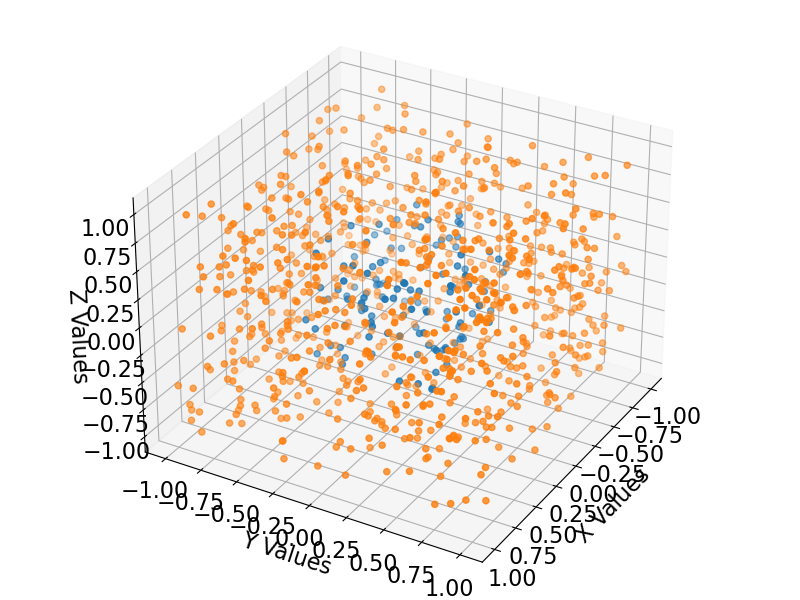

0.128

In [4]:
def cube_check(n=1000, plot=False):
    # The unit volumes of the accepted and rejected cubes are 1 and 8 respectively
    # If distributed uniformly, the probability P(accept) -> 0.125 when n is large
    # Initialization
    accept, reject = 0, 0
    accept_list = np.zeros((0,3))
    reject_list = np.zeros((0,3))
    
    # Generating number tables by using the built-in size parameter
    x = 2*np.random.uniform(size=(n)) - 1
    y = 2*np.random.uniform(size=(n)) - 1
    z = 2*np.random.uniform(size=(n)) - 1
    
    # Checking if points fall in the acceptable volume
    for i in range(n):
        arr = np.array([x[i],y[i],z[i]])
        if -0.5 < x[i] < 0.5 and -0.5 < y[i] < 0.5 and -0.5 < z[i] < 0.5:
            accept += 1
            accept_list = np.vstack((accept_list,arr))
        else:
            reject += 1
            reject_list = np.vstack((reject_list,arr))
    
    # Returning generated probability 
    probability = accept/(accept + reject)
    
    # Plotting points as a visual guide
    if plot:
        print("The number of accepted points is: {}".format(accept))
        print("The number of rejected points is: {}".format(reject))
        print("The probability of being in the smaller cube for {0} points is {1:.4g}".format(n,probability))
        
        accept_x, accept_y, accept_z = accept_list[:, 0], accept_list[:, 1], accept_list[:, 2]
        reject_x, reject_y, reject_z = reject_list[:, 0], reject_list[:, 1], reject_list[:, 2]
        
        # Plotting the accepted and rejected regions as 3D scatter graphs
        fig = plt.figure("Cube Test",figsize=(8,6))
        axes = Axes3D(fig)
        axes.scatter(accept_x, accept_y, accept_z)
        axes.scatter(reject_x, reject_y, reject_z)
        axes.set_xlabel("X Values")
        axes.set_ylabel("Y Values")
        axes.set_zlabel("Z Values")
        axes.view_init(30,30)
        plt.show()
    # Returns 0 to indicate success
    return probability

cube_check(1000, True)

Rotating the plot above, it is clear that these points are distributed in a fairly isotropic and random manner as no hyperplanes seem to form anywhere in this sample. Let's take a look at a distribution for more points:

Hence, NumPy's uniform table generator passes the spectral test and so is fit for use in simulations. 

Using a tool such as a Linear Congruential Generator would be useful, as they generate pseudorandom numbers (not truely random, but not correlated with the simulation process as thus are unbiased) that are replicable and reusable. However, they fail the spectral test, which is especially noticable with the RANDU implementation:

<IPython.core.display.Javascript object>


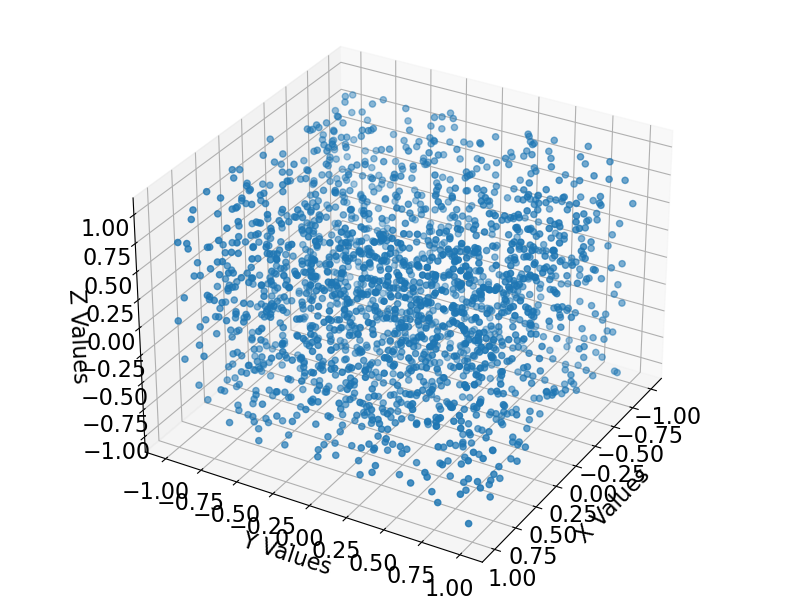

In [5]:
def cube_generator(n):
    # As with the list generator, but for a cube lattice with n points in 3 dimensions
    data = 2*np.random.uniform(size=(3,1,n)) - 1
    return data

uniform_cube = cube_generator(2000)
uni_x, uni_y, uni_z = uniform_cube[0, :], uniform_cube[1, :], uniform_cube[2, :]

fig = plt.figure("Uniformly Distributed 3D Array", figsize=(8,6))
axes = Axes3D(fig)
axes.scatter(uni_x, uni_y, uni_z)
axes.set_xlabel("X Values")
axes.set_ylabel("Y Values")
axes.set_zlabel("Z Values")
axes.view_init(30,30)
plt.show()

As seen above, a scatter plot of 2000 points does not seem to display the spectral problem, hence it can be assumed that the uniform generator works as expected and is fit for use in simulations.

Using a tool such as a Linear Congruential Generator would be useful, as they generate pseudorandom numbers (not truely random, but not correlated with the simulation process as thus are unbiased) that are replicable and reusable. However, they fail the spectral test, which is especially noticable with the RANDU implementation:

<IPython.core.display.Javascript object>


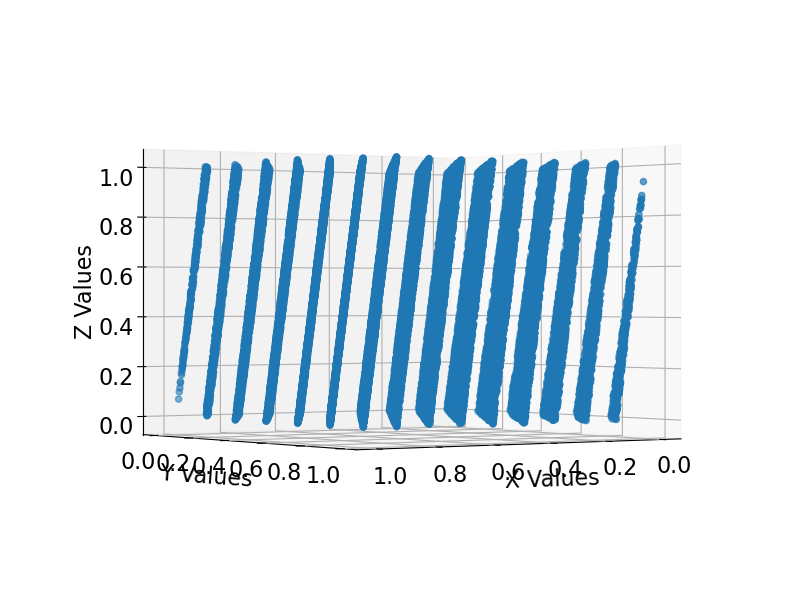

RANDU with 2000 points:


<IPython.core.display.Javascript object>


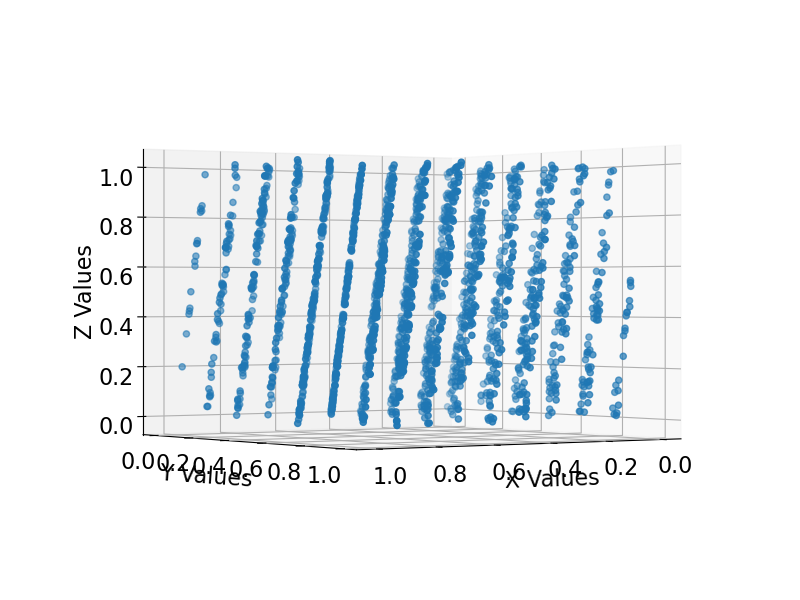

In [6]:
def randssp(p,q):   
    m = pow(2, 31)
    a = pow(2, 16) + 3
    c = 0
    x = 123456789
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m
    return r

randssp_cube = randssp(3,41700)
randssp_x, randssp_y, randssp_z = randssp_cube[0, :], randssp_cube[1, :], randssp_cube[2, :]

fig = plt.figure("RANDU Distributed 3D Array", figsize=(8,6))
axes = Axes3D(fig)
axes.scatter(randssp_x, randssp_y, randssp_z)
axes.set_xlabel("X Values")
axes.set_ylabel("Y Values")
axes.set_zlabel("Z Values")
axes.view_init(0,55)
plt.show()

print("RANDU with 2000 points:")
randssp_cube = randssp(3,2000)
randssp_x, randssp_y, randssp_z = randssp_cube[0, :], randssp_cube[1, :], randssp_cube[2, :]

fig = plt.figure("2000 RANDU Distributed Points", figsize=(8,6))
axes = Axes3D(fig)
axes.scatter(randssp_x, randssp_y, randssp_z)
axes.set_xlabel("X Values")
axes.set_ylabel("Y Values")
axes.set_zlabel("Z Values")
axes.view_init(0,55)
plt.show()

As seen above, for a large enough number of points, an LCG such as the RANDU implementation clearly suffers from the spectral problem. With 2000 points, the RANDU LCG still demonstrates the spectral problem, unlike the uniform tables at the same number of 3D points as the uniform table. 

What happens when using an LCG with other coefficients?

<IPython.core.display.Javascript object>


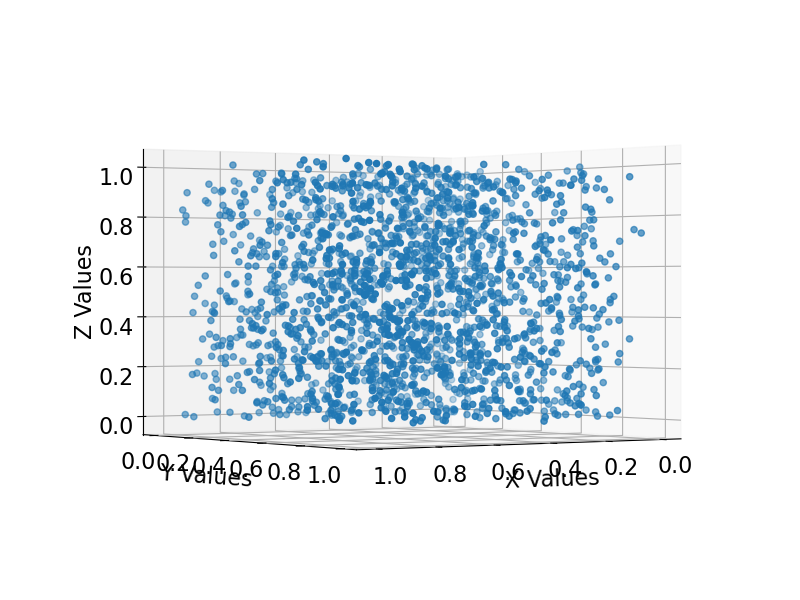

In [7]:
def LCG(p,q):   
    m = pow(2, 31)
    a = pow(2, 8) + 11
    c = 0
    x = 12789621
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m
    return r

lcg_cube = LCG(3,2000)
lcg_x, lcg_y, lcg_z = lcg_cube[0, :], lcg_cube[1, :], lcg_cube[2, :]

fig = plt.figure("LCG Distributed 3D Array", figsize=(8,6))
axes = Axes3D(fig)
axes.scatter(lcg_x, lcg_y, lcg_z)
axes.set_xlabel("X Values")
axes.set_ylabel("Y Values")
axes.set_zlabel("Z Values")
axes.view_init(0,55)
plt.show()

Other LCGs may be more random (as with the example above), though there is still the potential for some spectral properties. They also appear to be slower than the respective uniform table generator at the same number of points.

Hence, an LCG is not suitable for simulations of neutron scattering and absorbtion, whereas the NumPy uniform tables will be suitable.

## Part 2 - Generating Isotropic Steps Distributed to an Exponential Function

### Generating Step Lengths
As the uniform tables are suitable for use in simulation, the next step is to use them to generate isotropic steps distributed according to the inverse cumulative distribution function of the

If the probability of travelling a distance $x$ in a medium with mean free path $\lambda$ is: $PDF(x) = \exp(\frac{-x}{\lambda})$,
then the inverse cumulative probability distribution of probability $p$ is $x = CDF(p) = -\lambda \ln{(p)}$, so a random probability $[0,1)$ can map to some distance $x$ distributed according to the PDF.

The code below applies this method to some uniform $P ~ U[0,1)$, to generate values of $x$ distributed exponentially, using the expected mean free path of water for absorption only. These are then binned in a histogram to demonstrate the cumulative distribution of path distances.

[Non-Scattering] Water's Theoretical Mean Free Path (m): 0.4545


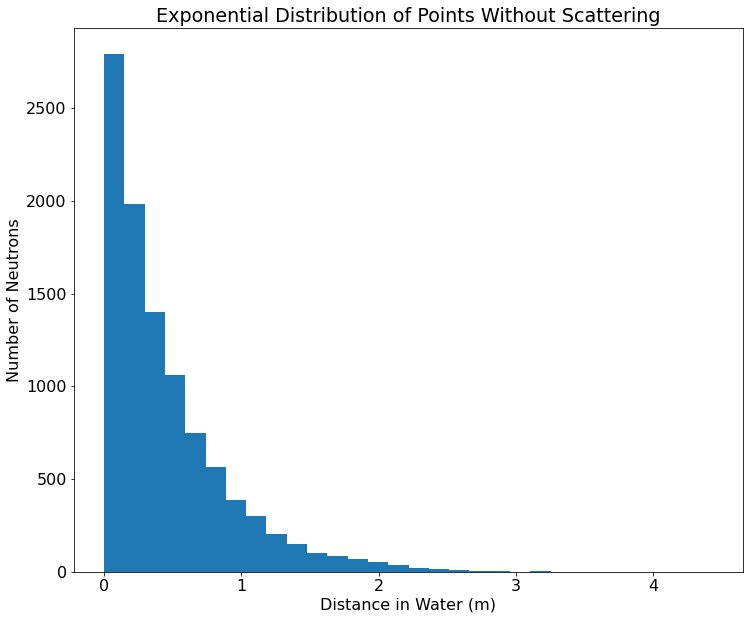

In [8]:
def generator(n, m=1):
    # Generate a uniformly distrbuted list of 'random' numbers, linear dimension n 
    # Values generated are 0 < x < 1
    if m == 1:
        x = np.random.uniform(size=(n))
    else:
        x = np.random.uniform(size=(n,m))
    return x

AMU_TO_KG = 1.661*10**-27 # 1 amu in kg
water_absorption = 0.6652 *10**-28 # in m^3, converted from barns (100 fm^2)
water_density = 1000 # in kg/m^3
water_molecule_mass = 18.2 # in amu

water_no_density = water_density/(water_molecule_mass*AMU_TO_KG) # in m^-3
water_mfp_theory = 1/(water_no_density*water_absorption) #in m
print("[Non-Scattering] Water's Theoretical Mean Free Path (m): {:.4g}".format(water_mfp_theory))

def inv_cdf_free_path(random, path):
    # Remaps a uniform random range [0,1) according to an exponential distribution+
    return -path * np.log(random)

random_set_x = generator(10000)
random_x_water = inv_cdf_free_path(random_set_x, water_mfp_theory)

accept, reject = 0, 0
distance_list = np.zeros((0,1))

for i in range(len(random_x_water)):
    distance_list = np.append(distance_list,random_x_water[i])

%matplotlib inline
plt.rcParams['font.size'] = '16'
fig = plt.figure(figsize=(12,10))
axes = fig.add_subplot(111)
axes.set_xlabel("Distance in Water (m)")
axes.set_ylabel("Number of Neutrons")
axes.set_title("Exponential Distribution of Points Without Scattering")
axes.hist(distance_list,bins=30)
plt.show()

As predicted by the theory, there are more neutrons that travel shorter distances than those that travel longer distances, in line with the exponential distribution. From this histogram, the mean free path of this particular simulation can be found by converting each bin into a point at their central distances, with the height of the bin as its y-value. This data is then reduced to logarithmic form so that the probability distribution is linearised to a form $\log(n) = -\lambda x + C$ where n is the number of neutrons at each distance point and C is some intercept. The mean free path represents the average length a particle can travel in a material before an interaction with a molecule within the material. For the absorbtion regime, $ \lambda = \frac{1}{n\sigma_{a}} = \frac{1}{\Sigma_{a}}$, where $n$ is the number density of molecules in the material and $\sigma_{a}$ and $\Sigma_{a}$ are the microscopic and macroscopic absorbtion cross-sections respectively. If a material can also scatter particles with some macroscopic cross section $\Sigma_{s}$, then the mean free path becomes $\lambda = \frac{1}{\Sigma_{a}+\Sigma{s}}$. The probability of absorbtion is the ratio of the macroscopic absorbtion cross-section to the mean free path, i.e. $P(absorb) = \frac{\Sigma_{a}}{\Sigma_{a}+\Sigma_{s}} = \frac{\sigma_{a}}{\sigma_{a}+\sigma_{s}}$

This can be fitted using NumPy's polyfit function to get a least-squares estimate of the mean free path:

Mean Free Path (m): 0.4774 +- 0.07894
Intercept: 7.784 +- 0.1732


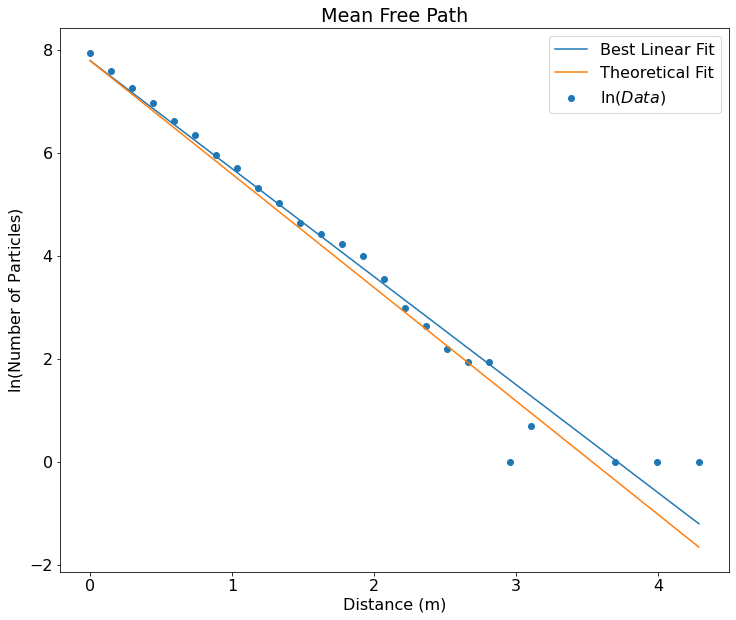

In [9]:
exp_hist_vals, exp_hist_edges = np.histogram(distance_list, bins=30)

# Need to run unscattered sim about 10 times and take average and variance of mfp
exp_data = np.zeros((0,2))
for i in range(len(exp_hist_edges)-1):
    number = exp_hist_vals[i]
    if number > 0:
        centre = np.mean(exp_hist_edges[i:i+1])
        temp_array = np.array([centre,number])
        exp_data = np.vstack((exp_data,temp_array))

exp_log_data = np.log(exp_data)

distance = exp_data[:,0]
log_number = exp_log_data[:,1]
popt, pcov = np.polyfit(distance, log_number, 1, cov=True)
mfp, intercept = -1/popt[0], popt[1]
errors = np.sqrt(np.diag(pcov))
mfp_error, intercept_error = errors[0], errors[1]

print("Mean Free Path (m): {0:.4g} +- {1:.4g}".format(mfp, mfp_error))
print("Intercept: {0:.4g} +- {1:.4g}".format(intercept, intercept_error))

fig = plt.figure(figsize=(12,10))
axes = fig.add_subplot(111)
axes.set_xlabel(r"Distance (m)")
axes.set_ylabel("$\ln$(Number of Particles)")
axes.scatter(exp_data[:,0],exp_log_data[:,1],label=r"$\ln{(Data)}$")
axes.plot(exp_data[:,0], -(1/mfp)*exp_data[:,0]+intercept, label="Best Linear Fit")
axes.plot(exp_data[:,0], -(1/water_mfp_theory)*exp_data[:,0]+intercept, label="Theoretical Fit")
axes.set_title("Mean Free Path")
axes.legend()
plt.show()

As with the probability tests before, repeating measurements and taking mean values will provide a result closer to the theoretical value of 0.4545 m, however a single simulation is somewhat close to this value.

### Generating Isotropic Vector Directions
Given that step lengths inside water can now be found accurately, the next step in simulating scattering is to be able to generate isotropic unit vectors such that when a scattering event occurs, it happens in a random direction with no bias (hence an LCG may not be appropriate for these simulations).

Given spherical coordinates: <br>
$x = r\sin{(\phi)}\cos(\theta)$ <br>
$y = r\sin{(\phi)}\sin(\theta)$ <br>
$z = r\cos{(\phi)}$ <br>
where $r$ is the radius of the sphere, $\theta$ is the circular angle in the x-y plane and $\phi$ is the azimuthal angle, we should expect clustering of points around the poles of the sphere as the probability is maximised.

in order to distribute $\theta$ correctly, the inverse cumulative distribution $\phi = CDF(u_{i})^{-1} = arccos(2u_{i} - 1)$ is used for a random uniform $u_{i}$.

<IPython.core.display.Javascript object>


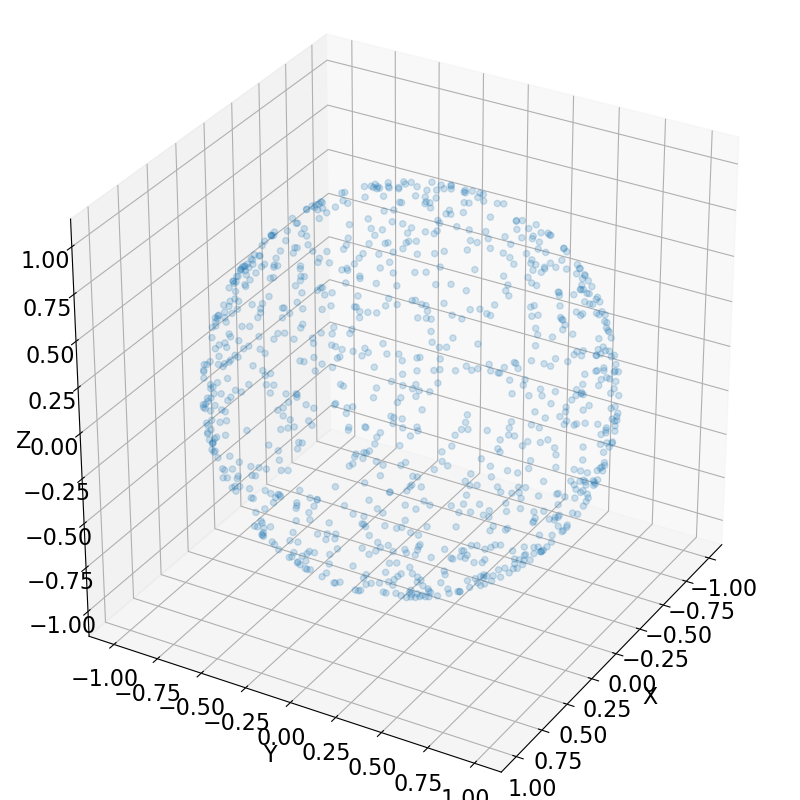

In [10]:
def inv_cdf_sin(theta_randoms):
    return np.arcsin(theta_randoms)

def inv_cdf_cos(theta_randoms):
    return np.arccos(theta_randoms)

def angle_generator(n):
    uniforms = generator(n, 2)
    isotropic_phi = np.arccos(2*uniforms[:,0] - 1)
    isotropic_theta = 2 * PI * uniforms[:,1]
    return isotropic_theta, isotropic_phi

def step_generator_3d(n, mean_free_path):
    uniform_step = generator(n)
    distributed_step = inv_cdf_free_path(uniform_step, mean_free_path)
    distributed_theta, distributed_phi = angle_generator(n)
    n = len(distributed_step)
    directions = np.zeros((n,3))
    for i in range(n):
        length = distributed_step[i]
        theta = distributed_theta[i]
        phi = distributed_phi[i]
        x_direction = length * np.cos(theta) * np.sin(phi)
        y_direction = length * np.sin(theta) * np.sin(phi)
        z_direction = length * np.cos(phi)
        direction = np.array([x_direction,y_direction,z_direction])
        direction = np.transpose(direction)
        directions[i] = direction
    return directions

uniform_step = generator(1000)
distributed_theta, distributed_phi = angle_generator(1000)
instructions = np.zeros((0,3))
directions = np.zeros((0,3))
for i in range(1000):
    length = 1
    theta = distributed_theta[i]
    phi = distributed_phi[i]
    instruction = np.array([length,theta,phi])
    x_direction = length * np.cos(theta) * np.sin(phi)
    y_direction = length * np.sin(theta) * np.sin(phi)
    z_direction = length * np.cos(phi)
    direction = np.array([x_direction,y_direction,z_direction])
    direction = np.transpose(direction)
    instructions = np.vstack((instructions, instruction))
    directions = np.vstack((directions, direction))

%matplotlib notebook
fig = plt.figure("Sample Unit Isotropic Distribution", figsize=(8,8))
axes = Axes3D(fig)
x = directions[:,0]
y = directions[:,1]
z = directions[:,2]
axes.scatter(x, y, z, alpha=0.2)
axes.set_xlabel("X")
axes.set_ylabel("Y")
axes.set_zlabel("Z")
axes.set_box_aspect((1,1,1))
axes.view_init(30,30)
plt.show()

As shown above, the generation of directions is isotropic, as there is no clustering around poles or at particular angles. When the step length generated from the mean free path is used as the radius of the vector, isotropic and statistically distributed steps can be generated for scattering events.

<IPython.core.display.Javascript object>


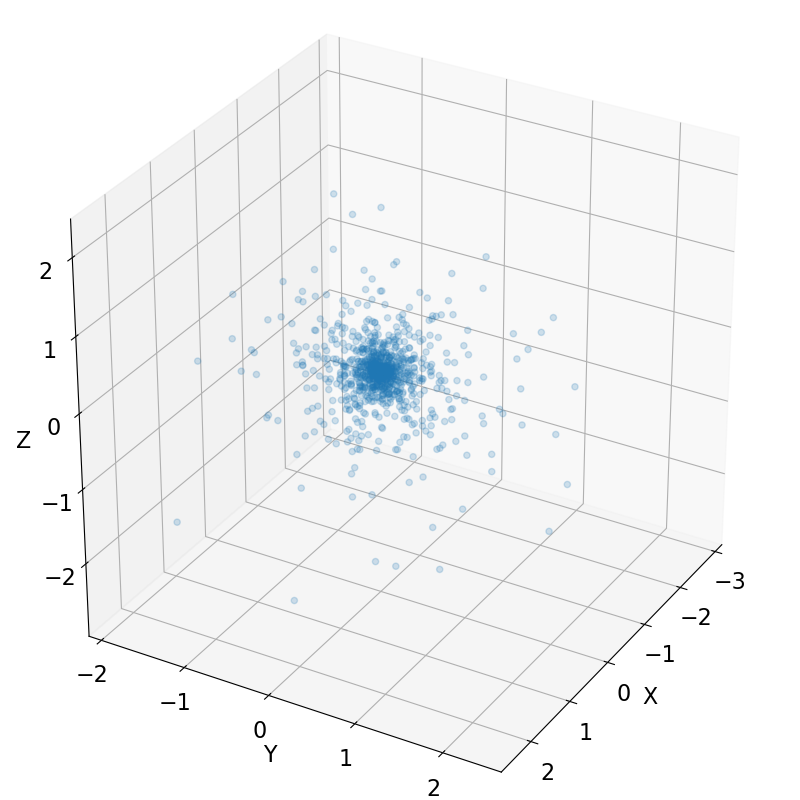

In [11]:
position = np.zeros((0,3))
for i in range(1000):
    start = np.array([[0,0,0]])
    position = np.vstack((position,start))
    
directions = step_generator_3d(1000, water_mfp_theory)
current_position = np.zeros((0,3))
for i in range(len(position[:,0])):
    new_position = position[i,:] + directions[i,:]
    current_position = np.vstack((current_position, new_position))
position = np.dstack((position, current_position))

fig = plt.figure("Sample Isotropic Distribution", figsize=(8,8))
axes = Axes3D(fig)
x = position[:,0,1]
y = position[:,1,1]
z = position[:,2,1]
axes.scatter(x, y, z, alpha=0.2)
axes.set_xlabel("X")
axes.set_ylabel("Y")
axes.set_zlabel("Z")
axes.set_box_aspect((1,1,1))
axes.view_init(30,30)
plt.show()

The steps are uniformly distributed in each direction, yet they remain more clustered near the point of interaction as expected. Hence, scattering events can be accurately simulated and thus an appropriate algorithm can now be written to find the scattering and and absorbtion events.

## Part 3 - Simulating Neutron Interaction Events

### Testing the Method
<b><u>SIMULATION METHOD</u></b>:
- Intialise the simulation by setting the number of scattering neutrons as the number of neutrons and the number of absorbed,     reflected and transmitted neutrons to be 0 each.
- Create a blank data array of size [nx6], where n is the number of neutrons. Each row represents a single neutrons and has the   structure [particle_history, steps, scattering, absorb, transmit, reflect]
    - particle_history is an array of the positions [x,y,z] of the neutron until its simulation is killed, with [0,0,0] being         the first entry (i.e. the length should be 1 + no. steps) - this allows the history of the neutron to be plotted.
    - steps is an integer representing how many steps were taken before an outcome was observed - this can be used to estimate         the mean number of steps before an outcome other than scattering occurs.
    - scattering, absorb, transmit and reflect are boolean flags representing their respective neutron outcomes.
- FOR each integer, i, in the range(0, n-1):
    - Generate a step from [0,0,0] in the x direction only, by distributing a uniform variable $X \sim X[0,1)$ according to the       inverse CDF of the intensity, then add to [0,0,0].  
    - WHILE the neutron is SCATTERING or the STEP number is less than a maximum (default 15):
        - Check whether the neutron is in the material or not:
            - IF x < 0:
                - Set SCATTERING to FALSE and subtract one from the number of scattering neutrons
                - Set REFLECT to TRUE and add one to the number of reflected neutrons
                - Break the loop
            - ELIF x > THICKNESS: then TRANSMIT, remove from SCATTERING:
                - Set SCATTERING to FALSE and subtract one from the number of scattering neutrons
                - Set REFLECT to TRUE and add one to the number of transmitted neutrons
                - Break the loop
            - ELSE, the particle is in the material
         - Assign a random probability between 0 and 1 via $X ~ U[0,1)$ and compare to the absorbtion probability
            - IF PROBABILITY < ABSORBTION PROBABILITY:
                - Set SCATTERING to FALSE and subtract one from the number of scattering neutrons
                - Set ABSORB to TRUE and add one to the number of absorbed neutrons
            - ELSE, the neutron must scatter:
                - Add one to the number of steps
                - Generate a step [x,y,z] through the isotropic unit vector generator, the inverse CDF of the intensity (step                     length) and the spherical coordinates to cartesian corrdinates relation.
                - Add the step to the previous position
                - Update the reference x-position for easy comparison
                - Stack the new position as a new row in the particle_hisotry array
    - Once the neutron's simulation has ended, append the generated data as a new row in the data array
- Once all simulations have finished, collate the neutron numbers in an array, calculate the probabilities of each event and       make an array of the probabilities
- RETURN the final data array, numbers array and the probabilities array

In [12]:
def plot_simulation(n, mean_free_path, absorb_probability, thickness, max_step=15, plot=False, material="Water"):
    if plot == True:
        fig = plt.figure("Random Paths Simulated in {}".format(material),figsize=(8,8))
        axes = Axes3D(fig)
    n_scattering = n
    n_reflect = 0
    n_transmit = 0
    n_absorb = 0
    data = np.zeros((n,6), dtype=object)
    for i in range(n):
        step = 0
        scattering = True
        absorb = False
        transmit = False
        reflect = False
        initial_position = np.array([0,0,0])
        random_x = np.random.uniform()
        first_step = -mean_free_path * np.log(random_x)
        next_position = [first_step, 0, 0]
        position_history = np.vstack((initial_position, next_position))
        step += 1
        x = first_step
        while scattering:
            if x < 0:
                scattering = False
                status = "Reflect"
                n_scattering -= 1
                n_reflect += 1
                break
            if x > thickness:
                scattering = False
                status = "Transmit"
                n_scattering -= 1
                n_transmit += 1
                break
            else:
                probability = np.random.uniform()
                if probability < absorb_probability:
                    scattering = False
                    status = "Absorb"
                    n_scattering -= 1
                    n_absorb += 1
                    break
                else:
                    # Generates a step as according to the step generator
                    step += 1
                    #direction = step_generator_3d(1, mean_free_path)
                    #x = direction[0,0]
                    #next_position = position_history[step-1] + direction
                    #position_history = np.vstack((position_history,next_position))
                
                    uniforms = np.random.uniform(size=(3))
                    length = -mean_free_path * np.log(uniforms[0])
                    phi = np.arccos(2*uniforms[1] - 1)
                    theta = 2 * PI * uniforms[2]
                    x_direction = length * np.cos(theta) * np.sin(phi)
                    y_direction = length * np.sin(theta) * np.sin(phi)
                    z_direction = length * np.cos(phi)
                    x += x_direction
                    direction = np.array([x_direction, y_direction, z_direction])
                    next_position = position_history[step-1] + direction
                    position_history = np.vstack((position_history,next_position))  
        if plot == True:
            x = position_history[:,0]
            y = position_history[:,1]
            z = position_history[:,2]
            if status == "Absorb":
                lines = "dotted"
            elif status == "Reflect":
                lines = "dashed"
            else:
                lines = "solid"
            axes.plot(x, y, z, linestyle=lines)
        
        data[i,0], data[i,1], data[i,2] = position_history, step, status
    if plot == True:
        axes.set_xlabel("X")
        axes.set_ylabel("Y")
        axes.set_zlabel("Z")
        axes.set_box_aspect((1,1,1))
        axes.view_init(30,30)
        plt.show()
    numbers = np.array([n_absorb, n_transmit, n_reflect])
    probabilities = numbers/n
    return data, numbers, probabilities

water_mfp_theory = 0.4545
neutron_number = 10000
thickness = 1
absorbtion_event_probability = 0.00645

start = time.time()
data, numbers, probability = plot_simulation(10000, 0.0029, absorbtion_event_probability, 0.1)
end = time.time()

mean_step = np.mean(data[:,1])
median_step = np.median(data[:,1])
std_step = np.std(data[:,1])

print("")
print("Results for Water of Thickness 0.1 m, Using 1 Simulation of 10000 Neutrons:")
print("--------------------------------------------------")
print("Probability of Absorbtion: {0:.4g}".format(probability[0]))
print("Number of Absorbed Neutrons: {0:.4g}".format(numbers[0]))
print("Number of Reflected Neutrons: {0:.4g}".format(numbers[2]))
print("Number of Transmitted Neutrons: {0:.4g}".format(numbers[1]))
print("Mean Number of Steps: {:.4g}".format(np.mean(data[:,1])))
print("Example Particle History: {}".format(data[0,0]))
print("Status: {}".format(data[0,2]))
print("Computational Time: {:.4g} s".format(end - start))


Results for Water of Thickness 0.1 m, Using 1 Simulation of 10000 Neutrons:
--------------------------------------------------
Probability of Absorbtion: 0.2051
Number of Absorbed Neutrons: 2051
Number of Reflected Neutrons: 7915
Number of Transmitted Neutrons: 34
Mean Number of Steps: 31.6
Example Particle History: [[ 0.          0.          0.        ]
 [ 0.00052785  0.          0.        ]
 [ 0.00193433  0.00288064 -0.00024119]
 [ 0.00348782  0.00078659 -0.00031754]
 [ 0.00512722  0.00053058 -0.00069658]
 [ 0.00500185 -0.00141178  0.00275301]
 [ 0.00408171 -0.003273    0.00291965]
 [ 0.00421516 -0.00339707  0.00294682]
 [ 0.00484262 -0.00277994  0.0027978 ]
 [ 0.00626946 -0.00011229  0.00110688]
 [ 0.00626541 -0.00010598  0.00110664]
 [ 0.00837327 -0.00020505  0.00160032]
 [ 0.00866757 -0.00588158  0.00585709]
 [ 0.00815867 -0.00484547  0.0044119 ]
 [ 0.00736538 -0.00551548  0.00465393]
 [ 0.00934551 -0.00743473 -0.00114736]
 [ 0.01066385 -0.00786403 -0.00011596]
 [ 0.01057597 -0.0

As seen above, the method appears to work competently and can neatly store the particle histories of every neutron in the simulation whilst also accurately keeping track of their status. However, the computational time involved in simulating each neutron individually is fairly high: it is on the order of 12 to 14 s for 10000 neutrons. However, this could be made more efficient by performing a bulk simulation model which only deals with simulating the x-axis of the neutron paths, returning the number of neutrons in each state and the calculated probabilities, without storing particle histories.

The logic of checking whether the neutrons are in the material or whether they are absorbed remains the same, except:
- Only one position in x is stored at once per neutron, in a single array where each entry represents a single neutron
- The logic is instead represented via using np.where() to detect where state is fulfilled and the lengths of each np.where() array are added to the tally of the number of neutrons in each state.
- Any neutrons that have transmitted, been absorbed or been reflected are removed from the position array
- Then, steps are generated simultaneously for all neutrons, resulting in far fewer calls of np.random.uniform() and thus a far reduced computational time
- This method should theoretically produce very similar results to the slower method

In [13]:
def simulation(n, mean_free_path, absorb_probability, thickness):
    """
    This is designed to be a faster and more efficient simulation.
    The particle history is not saved here as it would be far more complicated
    to implement when working with a single array.
    This is ideal for just simulating the steps in the x axis so that the
    numbers of each type of interaction can be extracted rather than generating
    all of the data required for plotting, as it is not required most of the
    time.
    """
    n_absorb = 0
    n_reflect = 0
    n_transmit = 0
    positions = np.zeros(n)
    x_uniforms = np.random.uniform(size=(n))
    x_steps = -mean_free_path * np.log(x_uniforms)
    positions += x_steps
    n_scattering = len(positions)
    # This section replaces the if statements of the slower method
    while n_scattering > 0:
        reflecting = np.where(positions < 0)[0]
        n_reflect += len(reflecting)
        positions = np.delete(positions, reflecting)
        
        transmitting = np.where(positions > thickness)[0]
        n_transmit += len(transmitting)
        positions = np.delete(positions, transmitting)
    
        n_scattering = len(positions)
        event_probabilities = np.random.uniform(size=(n_scattering))
        absorbing = np.where(event_probabilities < absorb_probability)[0]
        n_absorb += len(absorbing)
        positions = np.delete(positions, absorbing)
        
        n_scattering = len(positions)
        direction_uniforms = np.random.uniform(size=(3, n_scattering))
        lengths = -mean_free_path * np.log(direction_uniforms[0,:])
        theta = 2*PI*direction_uniforms[1,:]
        phi = np.arccos(2*direction_uniforms[2,:]-1)
        x_steps = lengths * np.cos(theta) * np.sin(phi)
        positions += x_steps
    numbers = np.array([n_absorb, n_transmit, n_reflect])
    probabilities = numbers/n
    return numbers, probabilities


start = time.time()
numbers, probability = simulation(10000, 0.0029, absorbtion_event_probability, 0.100)
end = time.time()

print("")
print("Results for Non-Scattering Water of Thickness 0.1 m, Using 1 Simulation of 10000 Neutrons:")
print("--------------------------------------------------")
print("Probability of Absorbtion: {0:.4g}".format(probability[0]))
print("Number of Absorbed Neutrons: {0:.4g}".format(numbers[0]))
print("Number of Reflected Neutrons: {0:.4g}".format(numbers[2]))
print("Number of Transmitted Neutrons: {0:.4g}".format(numbers[1]))
print("Computational Time: {:.4g} s".format(end - start))


Results for Non-Scattering Water of Thickness 0.1 m, Using 1 Simulation of 10000 Neutrons:
--------------------------------------------------
Probability of Absorbtion: 0.2056
Number of Absorbed Neutrons: 2056
Number of Reflected Neutrons: 7913
Number of Transmitted Neutrons: 31
Computational Time: 0.2135 s


This reduced method is far faster than the intial method and is far better suited for repetition, such as determining error and averaging results, as in each case the neutron histories are not the focus of the simulation, especially for many repetitions of a simulation of many neutrons. However, the slower method will be fast enough to be used for a simulation of a small number of neutrons - which is ideal for plotting and demonstrating how different materials interact with the neutrons.

When simulating each material, the following steps are required:
- Determine the macroscopic cross-sections (number density * microscopic cross section) and hence the mean free paths and         probabilities of absorbtion of each material
- Determine fraction of transmitted, reflected and absorbed neutrons and errors as number of simulated neutrons changes,
      i.e. perform several simulations (?) per value of n at a thickness of 0.1 m
- Plot some neutron paths - this is easily taken from a simulation's data array.
- Determine attenuation lengths from several thicknesses - this is the same method as finding the non-scattering attenuation       length of water, except it depends on the transmission number of the simulations.

### Simulating Material Interactions
Water: <br>
- Absorbtion Cross Section: 0.6652 barn = 0.6652 *10$^{-28}$ $m^{2}$ <br>
- Scattering Cross Section: 103 barn = 103 *10$^{-28}$ $m^{2}$ <br>
- Density = 1000 kg/m$^{3}$ <br>
- Molecular Mass = 18.02 amu <br><br>

Lead: <br>
- Absorbtion Cross Section : 0.158 barn <br>
- Scattering Cross Section: 11.221 barn <br>
- Density = 11350 kg/m$^{3}$ <br>
- Molecular Mass = 207.2 amu <br><br>

Graphite: <br>
- Absorbtion Cross Section: 0.0045 barns <br>
- Scattering Cross Section: 4.74 barns <br>
- Density = 1670 kg/m$^{3}$ <br>
- Molecular Mass = 12.011 amu <br><br>

Below, the covsersions to SI units are defined such that the accuracy that Python can work to can be maintained:

In [14]:
# Setting up the constants
AMU_TO_KG = 1.661*10**-27 # 1 amu in kg
water_absorbtion = 0.6652 *10**-28 # in m^2, converted from barns (100 fm^2)
water_scatter = 103*10**-28 #in m^2, also converted from barns
water_density = 1000 # in kg/m^3
water_molecule_mass = 18.2 # in amu

water_no_density = water_density/(water_molecule_mass*AMU_TO_KG) # in m^-3
water_mfp_full = 1/(water_no_density*(water_absorbtion + water_scatter)) #in m
print("Water's Theoretical Mean Free Path (m): {:.4g}".format(water_mfp_full))
water_absorb_prob = water_absorbtion/(water_absorbtion + water_scatter)
print("Water's Theoretical Absorbtion Probability: {:.4g}".format(water_absorb_prob))
                    

lead_absorbtion = 0.152 *10**-28 # in m^2, converted from barns (100 fm^2)
lead_scatter = 11.221*10**-28 #in m^2, also converted from barns
lead_density = 11350 # in kg/m^3
lead_molecule_mass = 207.2 # in amu

lead_no_density = water_density/(water_molecule_mass*AMU_TO_KG) # in m^-3
lead_mfp_full = 1/(water_no_density*(lead_absorbtion + lead_scatter)) #in m
print("Lead's Theoretical Mean Free Path (m): {:.4g}".format(lead_mfp_full))
lead_absorb_prob = lead_absorbtion/(lead_absorbtion + lead_scatter)
print("Lead's Theoretical Absorbtion Probability: {:.4g}".format(lead_absorb_prob))


graphite_absorbtion = 0.0045 *10**-28 # in m^2, converted from barns (100 fm^2)
graphite_scatter = 4.74*10**-28 #in m^2, also converted from barns
graphite_density = 1670 # in kg/m^3
graphite_molecule_mass = 12.011 # in amu

graphite_no_density = water_density/(water_molecule_mass*AMU_TO_KG) # in m^-3
graphite_mfp_full = 1/(water_no_density*(lead_absorbtion + lead_scatter)) #in m
print("Graphite's Theoretical Mean Free Path (m): {:.4g}".format(graphite_mfp_full))
graphite_absorb_prob = graphite_absorbtion/(graphite_absorbtion + graphite_scatter)
print("Graphite's Theoretical Absorbtion Probability: {:.4g}".format(graphite_absorb_prob))

Water's Theoretical Mean Free Path (m): 0.002916
Water's Theoretical Absorbtion Probability: 0.006417
Lead's Theoretical Mean Free Path (m): 0.02658
Lead's Theoretical Absorbtion Probability: 0.01336
Graphite's Theoretical Mean Free Path (m): 0.02658
Graphite's Theoretical Absorbtion Probability: 0.0009485


Given that each bin of data in a simulation is distributed according to a Gaussian distribution, the number of points in each bin should have an error on the order of its square root - i.e. for a simulation of 10000 points, we should expect an error on the number of transmitted neutrons on the order of 10 (assuming 10% absorbtion) to 100 (assuming all points absorb).

In [15]:
water_probabilities = np.zeros((10))
water_numbers = np.zeros((10,3))
start = time.time()
for i in range(10):
    numbers, probabilities = simulation(10000,0.002916,0.006417,0.1)
    water_probabilities[i] = probabilities[0]
    water_numbers[i] = numbers
end = time.time()

water_absorb_prob_mean = np.mean(water_probabilities)
water_absorb_prob_std = np.std(water_probabilities)
number_absorb_mean = np.mean(water_numbers[:,0])
number_absorb_std = np.std(water_numbers[:,0])
number_reflect_mean = np.mean(water_numbers[:,2])
number_reflect_std = np.std(water_numbers[:,2])
number_transmit_mean = np.mean(water_numbers[:,1])
number_transmit_std = np.std(water_numbers[:,1])
print("Results for Water of Thickness 0.1 m Using 10000 Neutrons:")
print("--------------------------------------------------")
print("Mean Probability of Absorbtion: {0:.4g} +- {1:.4g}, Expected Error: {2:.4g}".\
      format(water_absorb_prob_mean, water_absorb_prob_std,water_absorb_prob_mean/np.sqrt(number_absorb_mean)))
print("Mean Number of Absorbed Neutrons: {0:.4g} +- {1:.4g}, Expected Error: {2:.4g}"\
      .format(number_absorb_mean, number_absorb_std,np.sqrt(number_absorb_mean)))
print("Mean Number of Reflected Neutrons: {0:.4g} +- {1:.4g}, Expected Error: {2:.4g}"\
      .format(number_reflect_mean, number_reflect_std,np.sqrt(number_reflect_mean)))
print("Mean Number of Transmitted Neutrons: {0:.4g} +- {1:.4g}, Expected Error: {2:.4g}"\
      .format(number_transmit_mean, number_transmit_std,np.sqrt(number_transmit_mean)))
print("Computational Time: {:.4g} s".format(end - start))

# Plot the results here

Results for Water of Thickness 0.1 m Using 10000 Neutrons:
--------------------------------------------------
Mean Probability of Absorbtion: 0.1993 +- 0.004483, Expected Error: 0.004464
Mean Number of Absorbed Neutrons: 1993 +- 44.83, Expected Error: 44.64
Mean Number of Reflected Neutrons: 7968 +- 45.66, Expected Error: 89.27
Mean Number of Transmitted Neutrons: 38.6 +- 6.296, Expected Error: 6.213
Computational Time: 1.645 s


The errors using 10000 neutrons are as expected and are resonably accurate, notably the error on the number of neutrons absorbed is similar to the expectation using Gaussian statistics, and the probability of absorbtion has an error which is two orders of magnitude smaller than the probability. However, this script runs slowly due to the computational power required to simulate a set of 10000 neutrons 10 times. As the errors for simulations of 10000 neutrons are reasonable, less simulations could be used to produce an average, which would easily reduce simulation time. Alternatively, less neutrons could be simulated each time:

### Testing Errors with Neutron Number

To test how the errors are affected with the number of neutrons simulated, the process of simulating neutron collisions ten times will be repeated for a varying neutron count:
- 5000 neutrons
- 2500 neutrons
- 1000 neutrons
- 500 neutrons

For a given error on a bin of count m, we can expect a Gaussian distributed error of the order $\sqrt{m}$, and a percentage error (which will also be the error on the probability) of $\frac{1}{\sqrt{m}}$. This can be compared to the standard deviation of the individual probabilities of each event to check whether the simulation is accurate. The estimated error can also be used to check whether conditions such as increasing the number of repetitions will have an effect on the error of the probability of absorbtion. 


Results for Water of Thickness 0.1 m, Using 10 Simulations of 100000 Neutrons:
--------------------------------------------------
Mean Probability of Absorbtion: 0.2006 +- 0.001147, Expected Error: 0.001416
Mean Number of Absorbed Neutrons: 2.006e+04 +- 114.7, Expected Error: 141.6
Mean Number of Reflected Neutrons: 7.96e+04 +- 123.6, Expected Error: 282.1
Mean Number of Transmitted Neutrons: 338.5 +- 11.41, Expected Error: 18.4
Computational Time: 6.321 s

Results for Water of Thickness 0.1 m, Using 10 Simulations of 10000 Neutrons:
--------------------------------------------------
Mean Probability of Absorbtion: 0.2003 +- 0.003367, Expected Error: 0.004476
Mean Number of Absorbed Neutrons: 2003 +- 33.67, Expected Error: 44.76
Mean Number of Reflected Neutrons: 7966 +- 34.49, Expected Error: 89.25
Mean Number of Transmitted Neutrons: 30.9 +- 4.061, Expected Error: 5.559
Computational Time: 1.649 s

Results for Water of Thickness 0.1 m, Using 10 Simulations of 5000 Neutrons:
--------

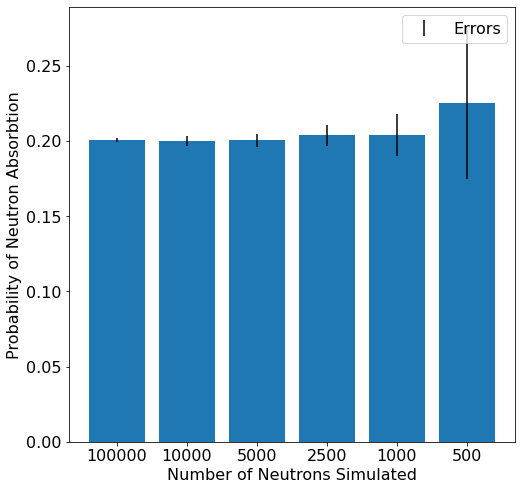

In [26]:
def multiple_simulations(n,m,mfp,absorb_prob,thickness,material,show_results=True):
    # m simulations of n neutrons
    start = time.time()
    total_probabilities = np.zeros((m,3))
    numbers_list = np.zeros((m,3))
    start = time.time()
    for i in range(m):
        numbers, probabilities = simulation(n,mfp,absorb_prob,thickness)
        total_probabilities[i] = probabilities
        numbers_list[i] = numbers

    absorb_prob_mean = np.mean(total_probabilities[:,0])
    absorb_prob_std = np.std(total_probabilities[:,0])
    reflect_prob_mean = np.mean(total_probabilities[:,2])
    reflect_prob_std = np.std(total_probabilities[:,2])
    transmit_prob_mean = np.mean(total_probabilities[:,1])
    transmit_prob_std = np.std(total_probabilities[:,1])
    
    number_absorb_mean = np.mean(numbers_list[:,0])
    number_absorb_std = np.std(numbers_list[:,0])
    number_reflect_mean = np.mean(numbers_list[:,2])
    number_reflect_std = np.std(numbers_list[:,2])
    number_transmit_mean = np.mean(numbers_list[:,1])
    number_transmit_std = np.std(numbers_list[:,1])
    end = time.time()
    if show_results:
        print("")
        print("Results for {} of Thickness {} m, Using {} Simulations of {} Neutrons:".format(material, thickness, m, n))
        print("--------------------------------------------------")
        print("Mean Probability of Absorbtion: {0:.4g} +- {1:.4g}, Expected Error: {2:.4g}"\
          .format(absorb_prob_mean, absorb_prob_std, absorb_prob_mean/np.sqrt(number_absorb_mean)))
        print("Mean Number of Absorbed Neutrons: {0:.4g} +- {1:.4g}, Expected Error: {2:.4g}"\
      .format(number_absorb_mean, number_absorb_std,np.sqrt(number_absorb_mean)))
        print("Mean Number of Reflected Neutrons: {0:.4g} +- {1:.4g}, Expected Error: {2:.4g}"\
      .format(number_reflect_mean, number_reflect_std,np.sqrt(number_reflect_mean)))
        print("Mean Number of Transmitted Neutrons: {0:.4g} +- {1:.4g}, Expected Error: {2:.4g}"\
      .format(number_transmit_mean, number_transmit_std,np.sqrt(number_transmit_mean)))
        print("Computational Time: {:.4g} s".format(end - start))
    probs_mean = [absorb_prob_mean, reflect_prob_mean, transmit_prob_mean]
    probs_std = [absorb_prob_std, reflect_prob_std, transmit_prob_std]
    return probs_mean, probs_std
"""    
data_set, numbers, probabilities = fast_simulation(10000,water_mfp_full,water_absorb_prob,0.1)
print(probabilities)
"""
neutron_numbers = [100000, 10000, 5000, 2500, 1000, 100]
x =[1,2,3,4,5,6]
absorb_numbers = np.zeros(6)
absorb_errors = np.zeros(6)
for i in range(len(neutron_numbers)):
    mean_probabilities, errors = multiple_simulations(neutron_numbers[i], 10, water_mfp_full, water_absorb_prob, 0.1, "Water")
    absorb_numbers[i], absorb_errors[i] = mean_probabilities[0], errors[0]
fig = plt.figure("Variation with Number of Neutrons Simulated",figsize=(8,8))
plt.xlabel("Number of Neutrons Simulated")
plt.ylabel("Probability of Neutron Absorbtion")
plt.bar(x, absorb_numbers, tick_label=["100000","10000","5000","2500","1000","500"])
plt.errorbar(x, absorb_numbers, absorb_errors, linestyle="none", color="black", label="Errors")
plt.legend()
plt.show()

It is notable that the probability of absorbtion and its error seem to be relatively consistent at the upper end of the order of 10$^{3}$ neutrons, however as the number of neutrons used in each simulation decreases, the error on the probability of absorbtion appears to increase by a factor of 10 for a decrease in neutron number by the same factor. This makes simulations of a small number of particles increasingly unreliable, especially as the probability can only be accurately known to the degree of $\frac{1}{n}$, hence a simulation of 500 neutrons can at best only be known to a definition of $\pm$ 0.002, which is better than the error demonstrated. However, a simulation of 10000 neutrons could be known at best to $\pm$ 0.0001, whilst still demonstrating a larger error than expected. In all cases, the error on the number pf neutrons in each state by the end of the simulation appears to be consistent with that expected for Gaussian statistics, though these represent larger percentage uncertainties (via $\frac{\Delta N}{N} = \frac{1}{\sqrt{N}}$) and so the variability between simulations will decrease as the number of neutrons simulated increases, though diminishing returns are expected so simulating more than 10000 neutrons at a time is unlikely to be advantageous.

### Testing Error with Repetitions

It is likely that the error on the probability of absorbtion can be decreased by performing more simulations, as this will better represent the most likely ranges of number of neutrons in each state, by virtue of having a larger sample size. The downside to running more simulations is that the computational time required to perform these calculations will have to increase according to $O(m)$, where $m$ is the number of simulations.

To minimise the computational time required to demonstrate this principle, 2500 neutrons will be used: 



Results for Water of Thickness 0.1 m, Using 20 Simulations of 2500 Neutrons:
--------------------------------------------------
Mean Probability of Absorbtion: 0.2011 +- 0.006598, Expected Error: 0.008969
Mean Number of Absorbed Neutrons: 502.8 +- 16.49, Expected Error: 22.42
Mean Number of Reflected Neutrons: 1989 +- 15.38, Expected Error: 44.59
Mean Number of Transmitted Neutrons: 8.5 +- 2.975, Expected Error: 2.915
Computational Time: 1.669 s

Results for Water of Thickness 0.1 m, Using 50 Simulations of 2500 Neutrons:
--------------------------------------------------
Mean Probability of Absorbtion: 0.203 +- 0.007061, Expected Error: 0.009011
Mean Number of Absorbed Neutrons: 507.5 +- 17.65, Expected Error: 22.53
Mean Number of Reflected Neutrons: 1985 +- 18.05, Expected Error: 44.55
Mean Number of Transmitted Neutrons: 7.86 +- 2.577, Expected Error: 2.804
Computational Time: 3.591 s

Results for Water of Thickness 0.1 m, Using 100 Simulations of 2500 Neutrons:
-------------------

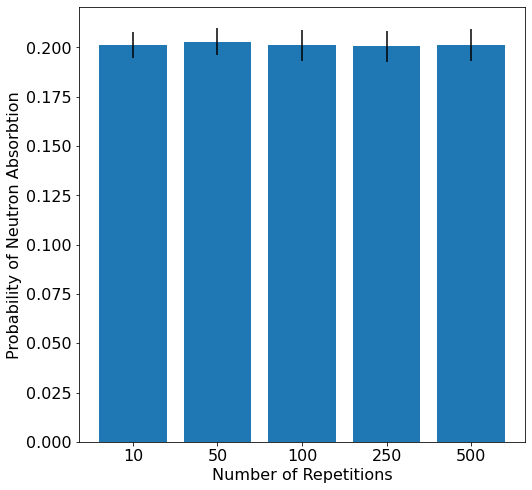

In [27]:
repetitions = [20, 50, 100, 250, 500]
x =[1,2,3,4,5]
absorb_numbers = np.zeros(5)
absorb_errors = np.zeros(5)
for i in range(len(repetitions)):
    mean_probabilities, errors = multiple_simulations(2500,repetitions[i], water_mfp_full, water_absorb_prob, 0.1, "Water")
    absorb_numbers[i], absorb_errors[i] = mean_probabilities[0], errors[0]
fig = plt.figure("Variation with Repetitions", figsize=(8,8))
plt.xlabel("Number of Repetitions")
plt.ylabel("Probability of Neutron Absorbtion")
plt.bar(x, absorb_numbers, tick_label=["10","50","100","250","500"], yerr=absorb_errors)
plt.show()

It appears that increasing the number of simulations performed for a set number of neutrons increases computational time, but does not present a significant enough reduction in error on the probability of absorbtion to justify increasing the number of simulations. Thus, it is highly likely that a far larger number of simulations are needed to significantly reduce the error, which will take an unreasonable computational time.

An ideal approach might be to use 20 simulations of 10000 neutrons at a time to maintain reasonable accuracy in a reasonable time, especially when calculating the number of neutrons that can transmit through different material thicknesses.

## Simulating the Absorbtion of Materials with a Thickness of 0.1 m


Results for Water of Thickness 0.1 m, Using 20 Simulations of 10000 Neutrons:
--------------------------------------------------
Mean Probability of Absorbtion: 0.2008 +- 0.004091, Expected Error: 0.004481
Mean Number of Absorbed Neutrons: 2008 +- 40.91, Expected Error: 44.81
Mean Number of Reflected Neutrons: 7958 +- 39.93, Expected Error: 89.21
Mean Number of Transmitted Neutrons: 33.85 +- 6.052, Expected Error: 5.818
Computational Time: 3.085 s

Results for Water of Thickness 0.1 m, Using 20 Simulations of 10000 Neutrons:
--------------------------------------------------
Mean Probability of Absorbtion: 0.09744 +- 0.003331, Expected Error: 0.003122
Mean Number of Absorbed Neutrons: 974.4 +- 33.31, Expected Error: 31.22
Mean Number of Reflected Neutrons: 6188 +- 41.7, Expected Error: 78.66
Mean Number of Transmitted Neutrons: 2838 +- 41.39, Expected Error: 53.27
Computational Time: 0.3381 s

Results for Water of Thickness 0.1 m, Using 20 Simulations of 10000 Neutrons:
--------------

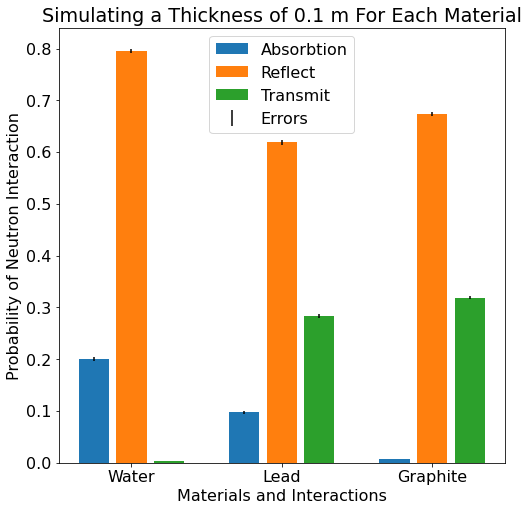

In [28]:
materials = ["Water", "Lead", "Graphite"]
mfp_list = [water_mfp_full, lead_mfp_full, graphite_mfp_full]
absorb_prob_list = [water_absorb_prob, lead_absorb_prob, graphite_absorb_prob]
x_absorb = [1,5,9]
x_reflect = [2,6,10]
x_transmit = [3,7,11]
absorb_numbers = np.zeros(3)
absorb_errors = np.zeros(3)
reflect_numbers = np.zeros(3)
reflect_errors = np.zeros(3)
transmit_numbers = np.zeros(3)
transmit_errors = np.zeros(3)
for i in range(len(mfp_list)):
    mean_absorb_number, error = multiple_simulations(10000, 20, mfp_list[i], absorb_prob_list[i], 0.1, "Water")
    absorb_numbers[i], absorb_errors[i] = mean_absorb_number[0], error[0]
    reflect_numbers[i], reflect_errors[i] = mean_absorb_number[1], error[1]
    transmit_numbers[i], transmit_errors[i] = mean_absorb_number[2], error[2]
fig = plt.figure("Simulating a Thickness of 0.1 m For Each Material",figsize=(8,8))
plt.title("Simulating a Thickness of 0.1 m For Each Material")
plt.xlabel("Materials and Interactions")
plt.ylabel("Probability of Neutron Interaction")
plt.bar(x_absorb, absorb_numbers, label="Absorbtion")
plt.bar(x_reflect, reflect_numbers, tick_label=["Water", "Lead", "Graphite"], label="Reflect")
plt.bar(x_transmit, transmit_numbers, label="Transmit")
plt.errorbar(x_absorb, absorb_numbers, absorb_errors, linestyle="none", color="black", label="Errors")
plt.errorbar(x_reflect, reflect_numbers, reflect_errors, linestyle="none", color="black")
plt.errorbar(x_transmit, transmit_numbers, transmit_errors, linestyle="none", color="black")
plt.legend(loc="upper center")
plt.show()

As can be seen above, all of the materials are very capable of reflecting neutrons at a thickness of 0.1 m, all providing an attenuation of at least 60% (from adding the absorbtion and reflection probabilities). Water is especially good for attenuating neutrons, given that it has both the highest probability of reflection and the highest probability of absorbtion, leading to an attenuation of about 99%. Water is likely to be very good at attenuation, due to being a highly chaotic liquid without regular arrangements, making collisions very likely despite the relatively low molecular mass. Water also takes a far longer time to simulate - this is becuase it has a small mean free path and a mean absorbtion probability around 0.6% per collision and so on average many more steps are required for a series of scattering events to result in a reflection or a transmission, given isotropic scattering distributions.

Lead has an overall attenuation of 70% at a thickness of 0.1 m, though it has a transmission rate of around 30%. Whilst lead is a dense crystal structure with molecules of high mass, it is also highly ordered and so it is more likely that neutron may be able to take uninterrupted paths through the material and thus transmit instead of absorbing.

Graphite has the lowest attenuation, just below 70% and has the highest transmission rate and lowest absorbtion rate of the materials. It is also a crystal structure, like lead, however each molecule has a far lower mass (and so is less likely to absorb neutrons via collisions) and is structured in planes seperated by a significant distance, so is more likely to transmit neutrons.

Below are some sample paths for each material. Dotted lines are absorbed neutrons, dashed lines are reflected neutrons and solid lines are transmitted neutrons. Only ten paths have been plotted, as the graphs would likely be too noisy if more were included. However, this means that the probabilities of each event are not properly represented in these diagrams, but they are useful as a way to visualise how neutrons scatter, especially as the probabilities of each event have already been found.

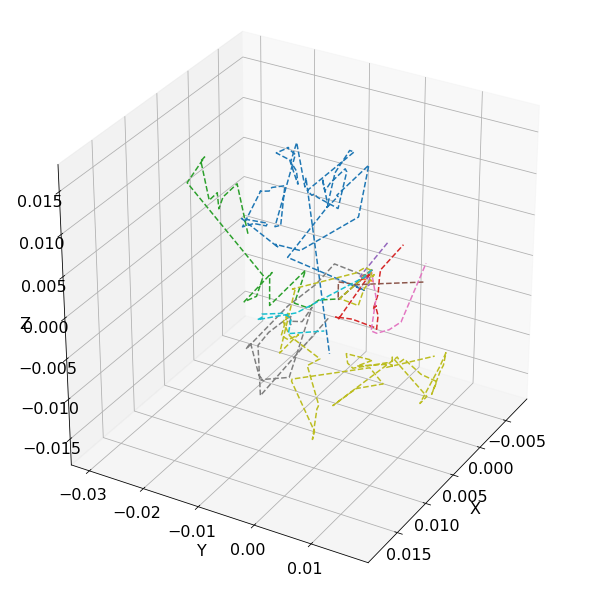

Mean Number of Steps: 20.4


In [29]:
data, number, probability= plot_simulation(10, water_mfp_full, water_absorb_prob, 0.100, plot=True, material="Water")
steps = data[:,1]
print("Mean Number of Steps: {:.4g}".format(np.mean(steps)))

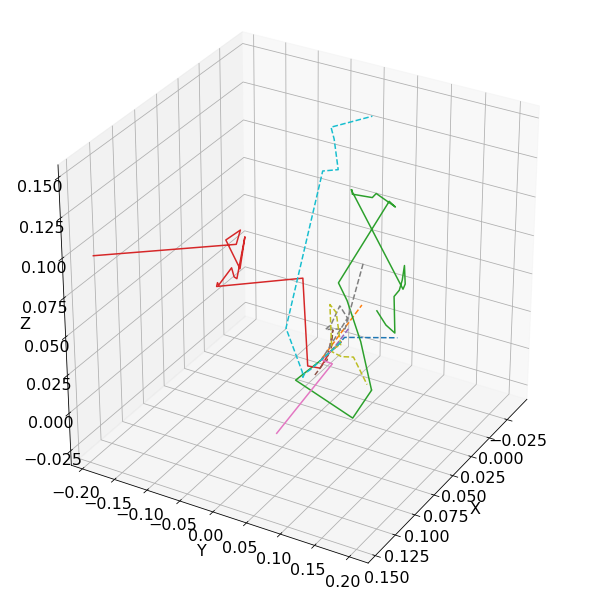

Mean Number of Steps: 8.1


In [30]:
data, number, probability= plot_simulation(10, lead_mfp_full, lead_absorb_prob, 0.100, plot=True, material="Lead")
steps = data[:,1]
print("Mean Number of Steps: {:.4g}".format(np.mean(steps)))

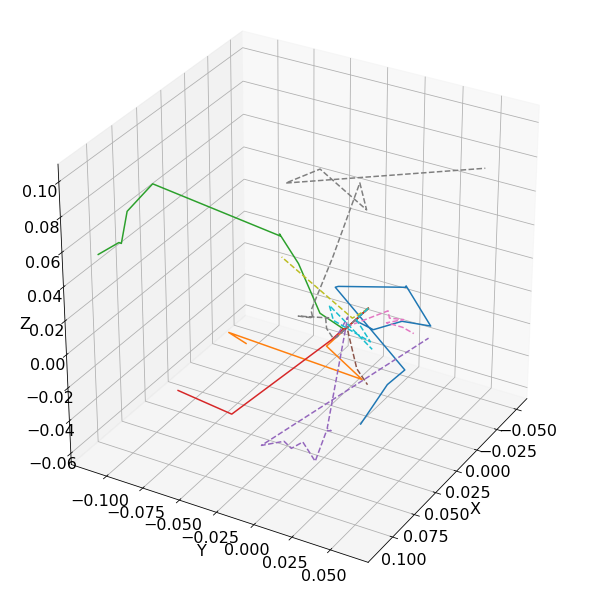

Mean Number of Steps: 7.4


In [31]:
data, number, probability= plot_simulation(10, graphite_mfp_full, graphite_absorb_prob, 0.100, plot=True, material="Graphite")
steps = data[:,1]
print("Mean Number of Steps: {:.4g}".format(np.mean(steps)))

Water easily has the most interaction with individual neutrons, as the paths are made up of far more points on average, especially compared to lead or graphite, which helps to explain why it tends to reflect more neutrons than the others - many scattering events with small step lengths increases the likelihood that a particle stays near the point of incidence and so it becomes more likely that individual neutrons may backscatter out of the material. This also explains why water is a more computationally expensive material to simulate - it requires more steps on average to simulate each neutron to their respective terminations.

## Finding the Attenuation Lengths of Each Material
Attenuation lengths are found using a similar method as before:

The intensity of a particle beam (i.e. the number transmitted through a material) can be described using the equation $I(x) = I(0)\exp{(\frac{x}{\lambda})}$, where $I(0)$ would be the number of neutrons incident on the material, $x$ would be the thickness of the material and $\lambda$ is the characteristic attenuation length. On average, a particle beam that has travelled through a thickness equal to $\lambda$ will have a decrease in intensity to a factor of $\frac{I(0)}{e}$. These lengths can be found by simulating materials at many thicknesses, binning the data according to the events that occur and fitting the logarithm of the transmitted neutrons to a linear relation with distance.

Unlike the previous case, this also accounts for scattering events and reflection of neutrons from the material and so does not represent the mean free path. As advised, each material has been simulated at small distances because each method is very sensitive for large thicknesses and so are more prone to producing erratic results.

In [22]:
%matplotlib inline
plt.rcParams['font.size'] = '16'
def attenuation(thicknesses, mfp, absorb_prob, material):
    bar_width = thicknesses[1] - thicknesses[0]
    mean_absorb_probabilities = np.zeros(len(thicknesses))
    mean_reflect_probabilities = np.zeros(len(thicknesses))
    mean_transmit_probabilities = np.zeros(len(thicknesses))
    absorb_errors = np.zeros(len(thicknesses))
    reflect_errors = np.zeros(len(thicknesses))
    transmit_errors = np.zeros(len(thicknesses))
    for i in range(len(thicknesses)):
        mean_probabilities, errors = multiple_simulations(10000, 20, mfp, absorb_prob, thicknesses[i], material)
        mean_absorb_probabilities[i] = mean_probabilities[0]
        mean_reflect_probabilities[i] = mean_probabilities[1]
        mean_transmit_probabilities[i] = mean_probabilities[2]
        absorb_errors[i] = errors[0]
        reflect_errors[i] = errors[1]
        transmit_errors[i] = errors[2]
    fig = plt.figure("Attenutaion of {}".format(material),figsize=(16,10))
    ax = fig.add_subplot(221)
    ax.errorbar(thicknesses, mean_reflect_probabilities, reflect_errors, label="Reflection")
    ax.errorbar(thicknesses, mean_absorb_probabilities, absorb_errors, label="Absorption")
    ax.errorbar(thicknesses, mean_transmit_probabilities, transmit_errors, label="Transmission")
    ax.set_xlabel("Thickness (m)")
    ax.set_ylabel("Probability of Event")
    ax.set_title("Probability of Events with Thickness")
    ax.legend()

    ax_2 = fig.add_subplot(222)
    ax_2.bar(thicknesses, mean_reflect_probabilities, yerr=reflect_errors, width=bar_width)
    ax_2.bar(thicknesses, mean_absorb_probabilities, yerr=absorb_errors, bottom=mean_reflect_probabilities, width=bar_width)
    ax_2.bar(thicknesses, mean_transmit_probabilities, yerr=transmit_errors,\
        bottom=mean_reflect_probabilities+mean_absorb_probabilities, width=bar_width)
    ax_2.set_xlabel("Thickness (m)")
    ax_2.set_ylabel("Probability of Event")
    ax_2.set_title("Bar Chart of Probabilities")

    # Need to np.where() zero points, then delete
    zeros = np.where(mean_transmit_probabilities <= 0)[0]
    mean_transmit_probabilities = np.delete(mean_transmit_probabilities, zeros)
    transmit_errors = np.delete(transmit_errors, zeros)
    
    log_transmit_probs = np.log(mean_transmit_probabilities)
    log_transmit_errs = transmit_errors/mean_transmit_probabilities

    distance = exp_data[:,0]
    log_number = exp_log_data[:,1]
    popt, pcov = np.polyfit(thicknesses, log_transmit_probs, 1, cov=True)
    atten_length, intercept = -1/popt[0], popt[1]
    errors = np.sqrt(np.diag(pcov))
    atten_length_error, intercept_error = abs(errors[0]/popt[0] * atten_length), errors[1]

    ax_3 = fig.add_subplot(212)
    ax_3.errorbar(thicknesses, log_transmit_probs, log_transmit_errs, linestyle="none", label="Logarithmic Data")
    ax_3.plot(thicknesses, thicknesses*(-1/atten_length) + intercept, label="Line of Best Fit", linestyle="dashed",\
              color="green")
    ax_3.set_xlabel("Thickness (m)")
    ax_3.set_ylabel(r"$\ln$(Probability of Transmission)")
    ax_3.set_title("Logarithmic Plot of Transmission Probability")
    ax_3.legend()
    plt.tight_layout()
    plt.show()

    print("Attenuation Length of {0} (m): {1:.4g} +- {2:.4g}".format(material, atten_length, atten_length_error))
    return atten_length, atten_length_error


Results for Water of Thickness 0.002 m, Using 20 Simulations of 10000 Neutrons:
--------------------------------------------------
Mean Probability of Absorbtion: 0.006535 +- 0.0006821, Expected Error: 0.0008084
Mean Number of Absorbed Neutrons: 65.35 +- 6.821, Expected Error: 8.084
Mean Number of Reflected Neutrons: 2552 +- 35.84, Expected Error: 50.52
Mean Number of Transmitted Neutrons: 7382 +- 35.03, Expected Error: 85.92
Computational Time: 0.1213 s

Results for Water of Thickness 0.004 m, Using 20 Simulations of 10000 Neutrons:
--------------------------------------------------
Mean Probability of Absorbtion: 0.01508 +- 0.0007999, Expected Error: 0.001228
Mean Number of Absorbed Neutrons: 150.8 +- 7.999, Expected Error: 12.28
Mean Number of Reflected Neutrons: 4100 +- 52.04, Expected Error: 64.03
Mean Number of Transmitted Neutrons: 5749 +- 52.43, Expected Error: 75.82
Computational Time: 0.1852 s

Results for Water of Thickness 0.006 m, Using 20 Simulations of 10000 Neutrons:
-

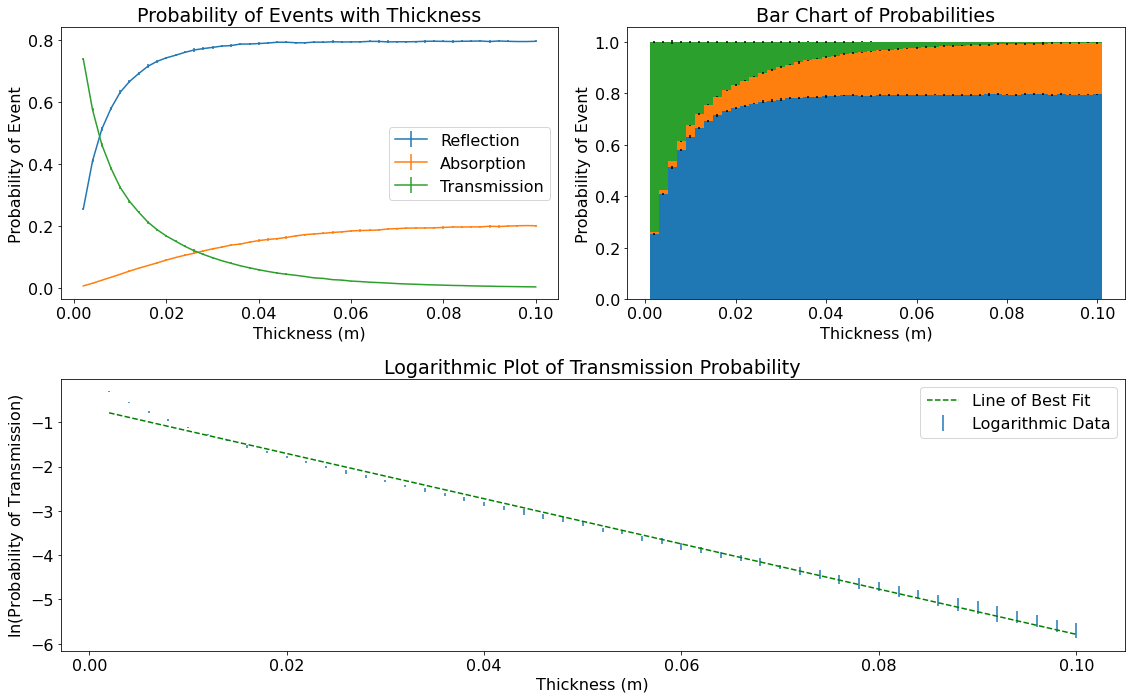

Attenuation Length of Water (m): 0.01961 +- 0.0002237


(0.019610805955109306, 0.0002236639143368855)

In [23]:
thicknesses = np.array([(x+1)/500 for x in range(50)])
attenuation(thicknesses, water_mfp_full, water_absorb_prob, "Water")


Results for Lead of Thickness 0.002 m, Using 20 Simulations of 10000 Neutrons:
--------------------------------------------------
Mean Probability of Absorbtion: 0.00128 +- 0.0003043, Expected Error: 0.0003578
Mean Number of Absorbed Neutrons: 12.8 +- 3.043, Expected Error: 3.578
Mean Number of Reflected Neutrons: 358.7 +- 15.26, Expected Error: 18.94
Mean Number of Transmitted Neutrons: 9628 +- 15.65, Expected Error: 98.12
Computational Time: 0.02033 s

Results for Lead of Thickness 0.004 m, Using 20 Simulations of 10000 Neutrons:
--------------------------------------------------
Mean Probability of Absorbtion: 0.002225 +- 0.0004073, Expected Error: 0.0004717
Mean Number of Absorbed Neutrons: 22.25 +- 4.073, Expected Error: 4.717
Mean Number of Reflected Neutrons: 696.6 +- 16.22, Expected Error: 26.39
Mean Number of Transmitted Neutrons: 9281 +- 16.77, Expected Error: 96.34
Computational Time: 0.02659 s

Results for Lead of Thickness 0.006 m, Using 20 Simulations of 10000 Neutrons:


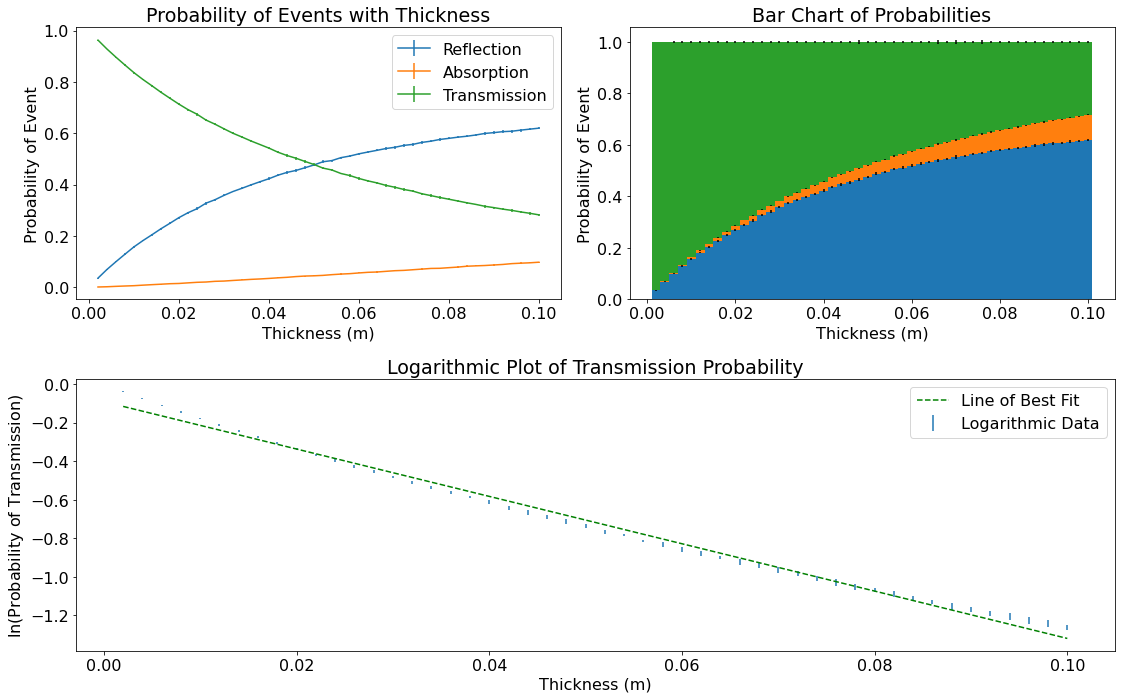

Attenuation Length of Lead (m): 0.08142 +- 0.001027


(0.08142010371947973, 0.0010265187101332859)

In [24]:
attenuation(thicknesses, lead_mfp_full, lead_absorb_prob, "Lead")


Results for Graphite of Thickness 0.002 m, Using 20 Simulations of 10000 Neutrons:
--------------------------------------------------
Mean Probability of Absorbtion: 7e-05 +- 8.426e-05, Expected Error: 8.367e-05
Mean Number of Absorbed Neutrons: 0.7 +- 0.8426, Expected Error: 0.8367
Mean Number of Reflected Neutrons: 363 +- 16.95, Expected Error: 19.05
Mean Number of Transmitted Neutrons: 9636 +- 17.24, Expected Error: 98.16
Computational Time: 0.02049 s

Results for Graphite of Thickness 0.004 m, Using 20 Simulations of 10000 Neutrons:
--------------------------------------------------
Mean Probability of Absorbtion: 0.000205 +- 0.0001071, Expected Error: 0.0001432
Mean Number of Absorbed Neutrons: 2.05 +- 1.071, Expected Error: 1.432
Mean Number of Reflected Neutrons: 697.1 +- 28.09, Expected Error: 26.4
Mean Number of Transmitted Neutrons: 9301 +- 28.04, Expected Error: 96.44
Computational Time: 0.02673 s

Results for Graphite of Thickness 0.006 m, Using 20 Simulations of 10000 Neu

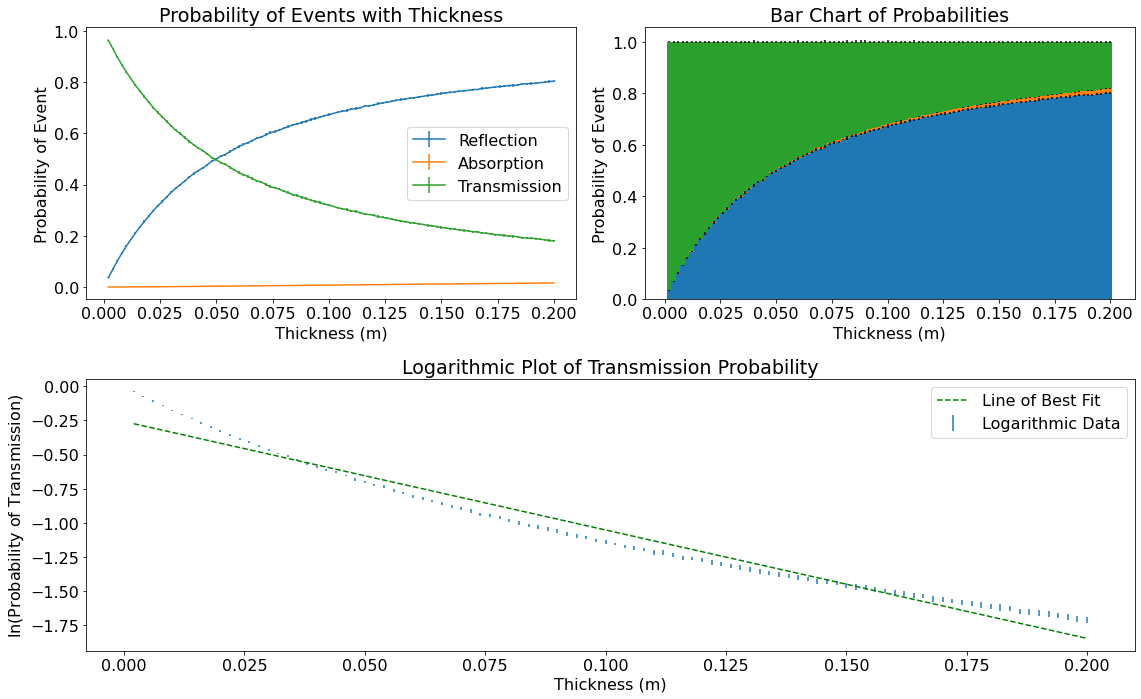

Attenuation Length of Graphite (m): 0.1259 +- 0.002321


(0.1259146715046506, 0.0023205867573541598)

In [25]:
thicknesses = np.array([(x+1)/500 for x in range(100)])
attenuation(thicknesses, graphite_mfp_full, graphite_absorb_prob, "Graphite")

As seen above, the attenuation lengths are as follows:
- ~2 cm in water
- ~8/9 cm in lead
- ~12/13 cm in graphite

These results are roughly in keeping with what is expected of these materials: water is very good at absorbing and reflecting neutrons, so does not allow many to pass, lead absorbs less neutrons but is less reflective tand so allows more to pass and graphite is very poor at absorbing neutrons